In [ ]:
!pip install arff2pandas

  Created wheel for arff2pandas: filename=arff2pandas-1.0.1-cp37-none-any.whl size=2197 sha256=fca17789a3820e3a7bb555d74188eb735dfd04d36936b3a18d448d3b06a194dd
  Stored in directory: /root/.cache/pip/wheels/b9/45/8c/f5549147a19665e4358e6b463bfdd0cb770f6ef38f3e137284
  Created wheel for liac-arff: filename=liac_arff-2.5.0-cp37-none-any.whl size=11732 sha256=9e9e81ca44b5f4885a06423dae4695cd4ec85b13cad0fb2b352b9f62373b6245
  Stored in directory: /root/.cache/pip/wheels/77/8d/b4/8bfce5beea9a3496cc15b24961876adb7b6e2912ff09164179
Successfully built arff2pandas liac-arff


In [ ]:
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F
from arff2pandas import a2p

# Data

The dataset contains 5,000 Time Series examples (obtained with ECG) with 140 timesteps. Each sequence corresponds to a single heartbeat from a single patient with congestive heart failure.

We have 5 types of hearbeats (classes):
*   Normal (N)
*   R-on-T Premature Ventricular Contraction (R-on-T PVC)
*   Premature Ventricular Contraction (PVC)
*   Supra-ventricular Premature or Ectopic Beat (SP or EB)
*   Unclassified Beat (UB)













In [ ]:
!gdown --id 16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT

Downloading...
From: https://drive.google.com/uc?id=16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT
To: /content/ECG5000.zip
10.6MB [00:00, 40.2MB/s]


In [ ]:
!unzip -qq ECG5000.zip

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# loading the arff files into Pandas data frames

with open('ECG5000_TRAIN.arff') as f:
  train = a2p.load(f)

with open('ECG5000_TEST.arff') as f:
  test = a2p.load(f)

In [ ]:
# combining the training and test data into a single data frame and shuffling to get more data to train the Autoencoder

df = train.append(test)
df = df.sample(frac=1.0)
df.shape

(5000, 141)

In [ ]:
df.head()

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,att11@NUMERIC,att12@NUMERIC,att13@NUMERIC,att14@NUMERIC,att15@NUMERIC,att16@NUMERIC,att17@NUMERIC,att18@NUMERIC,att19@NUMERIC,att20@NUMERIC,att21@NUMERIC,att22@NUMERIC,att23@NUMERIC,att24@NUMERIC,att25@NUMERIC,att26@NUMERIC,att27@NUMERIC,att28@NUMERIC,att29@NUMERIC,att30@NUMERIC,att31@NUMERIC,att32@NUMERIC,att33@NUMERIC,att34@NUMERIC,att35@NUMERIC,att36@NUMERIC,att37@NUMERIC,att38@NUMERIC,att39@NUMERIC,att40@NUMERIC,...,att102@NUMERIC,att103@NUMERIC,att104@NUMERIC,att105@NUMERIC,att106@NUMERIC,att107@NUMERIC,att108@NUMERIC,att109@NUMERIC,att110@NUMERIC,att111@NUMERIC,att112@NUMERIC,att113@NUMERIC,att114@NUMERIC,att115@NUMERIC,att116@NUMERIC,att117@NUMERIC,att118@NUMERIC,att119@NUMERIC,att120@NUMERIC,att121@NUMERIC,att122@NUMERIC,att123@NUMERIC,att124@NUMERIC,att125@NUMERIC,att126@NUMERIC,att127@NUMERIC,att128@NUMERIC,att129@NUMERIC,att130@NUMERIC,att131@NUMERIC,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC,"target@{1,2,3,4,5}"
2555,-1.176785,-3.349004,-4.063841,-3.984343,-3.111322,-2.152486,-1.807656,-1.203567,-0.453912,-0.365893,-0.366562,-0.411484,-0.453041,-0.465546,-0.395956,-0.432165,-0.421980,-0.429117,-0.427749,-0.471166,-0.482380,-0.532202,-0.568115,-0.570120,-0.660023,-0.628573,-0.648312,-0.757067,-0.768544,-0.773629,-0.831792,-0.905336,-0.992546,-0.971945,-1.037141,-1.106698,-1.108586,-1.179939,-1.173720,-1.070255,...,1.659499,1.973275,2.102269,2.061714,1.896499,1.669799,1.528962,1.229399,0.942089,0.508490,0.142937,0.082797,-0.094462,-0.138810,-0.028376,-0.066176,-0.158886,-0.107480,-0.061818,-0.096060,-0.096311,-0.174244,-0.138882,-0.092086,-0.018855,0.013203,0.107734,0.590842,1.228001,1.195388,0.620749,0.838030,0.955196,0.904258,0.906415,0.579471,0.811242,1.636637,0.691486,1
3633,-1.191352,-2.185252,-2.819151,-3.281118,-3.122596,-2.816660,-2.306513,-1.678055,-1.163103,-0.927237,-0.880206,-0.577088,-0.100023,0.104746,0.152496,0.141810,0.142317,0.097129,0.203239,0.172243,0.174109,0.133858,0.165567,0.220038,0.168993,0.138172,0.214378,0.157961,0.067773,0.099844,0.142255,0.027187,0.086025,0.091577,-0.022672,0.063891,0.040043,-0.010008,-0.080498,-0.039886,...,0.877534,0.879431,0.874898,0.928520,0.978722,0.992411,0.963627,0.998927,1.056830,1.080360,1.054026,1.056439,0.986313,0.964808,1.058910,0.992020,0.986940,0.931259,0.783500,0.600815,0.614556,0.748674,0.667903,0.541020,0.421532,0.315898,0.223758,0.292712,0.420879,0.201097,-0.218783,-0.711405,-1.262576,-1.850971,-2.424598,-3.447404,-3.545663,-3.310902,-2.098635,2
1232,-1.669490,-2.602449,-2.447170,-2.994281,-3.417635,-3.513930,-2.849957,-1.676115,-0.954008,-0.726140,-0.142844,0.196470,0.204327,0.114744,0.135485,0.110196,0.187434,0.196268,0.102857,0.089645,0.097316,0.070136,0.015197,0.048688,0.094023,0.085379,0.035646,-0.076474,0.050902,0.044853,-0.092908,-0.067923,-0.056730,-0.081737,-0.096991,-0.009367,-0.100436,-0.194603,-0.162959,-0.042795,...,0.912374,1.099336,1.155895,1.355503,1.481714,1.449280,1.271781,1.115306,0.971907,0.791301,0.610281,0.454923,0.283158,0.068556,-0.178841,-0.215922,-0.199172,-0.300410,-0.292868,-0.299370,-0.308728,-0.295243,-0.332278,-0.350785,-0.315891,-0.264337,-0.242742,-0.299811,-0.216681,0.045538,0.825186,2.002586,2.044285,1.653927,0.934122,-0.665812,-2.937087,-3.928920,-4.140944,1
362,-0.609860,-0.955111,-1.050200,-1.529374,-1.584854,-1.980893,-2.175911,-2.099942,-1.847231,-1.482936,-0.999167,-0.575339,-0.364994,-0.312387,-0.233858,-0.007861,0.193361,0.310181,0.314480,0.299584,0.291257,0.281405,0.361299,0.327943,0.323130,0.368441,0.364352,0.326038,0.267479,0.338529,0.371947,0.358851,0.338746,0.325617,0.318293,0.281405,0.340084,0.359215,0.290015,0.266852,...,0.422902,0.449392,0.447380,0.470515,0.504221,0.471211,0.452548,0.489736,0.477203,0.472394,0.543658,0.532073,0.529768,0.633395,0.560483,0.525801,0.497940,0.294021,0.2674

In [ ]:
# naming the possible classes
CLASS_NORMAL = 1

class_names = ['Normal','R on T','PVC','SP','UB']

In [ ]:
# renaming last column to target

new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

# Exploratory Data Analysis

In [ ]:
# checking number of heartbeats for each Heartbeat class
df.target.value_counts()

1    2919
2    1767
4     194
3      96
5      24
Name: target, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


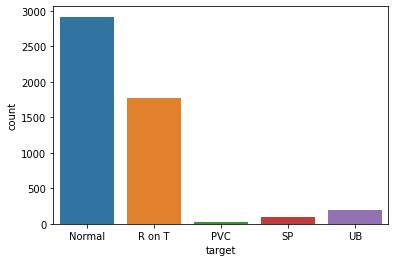

In [ ]:
# plotting the results
ax = sns.countplot(df.target)
ax.set_xticklabels(class_names);

The normal class has the most examples. Hence, we'll use it to train our model.

In [ ]:
# function to plot averaged (smoothed out with one standard deviation on top and bottom of it) Time Series for each class

def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)

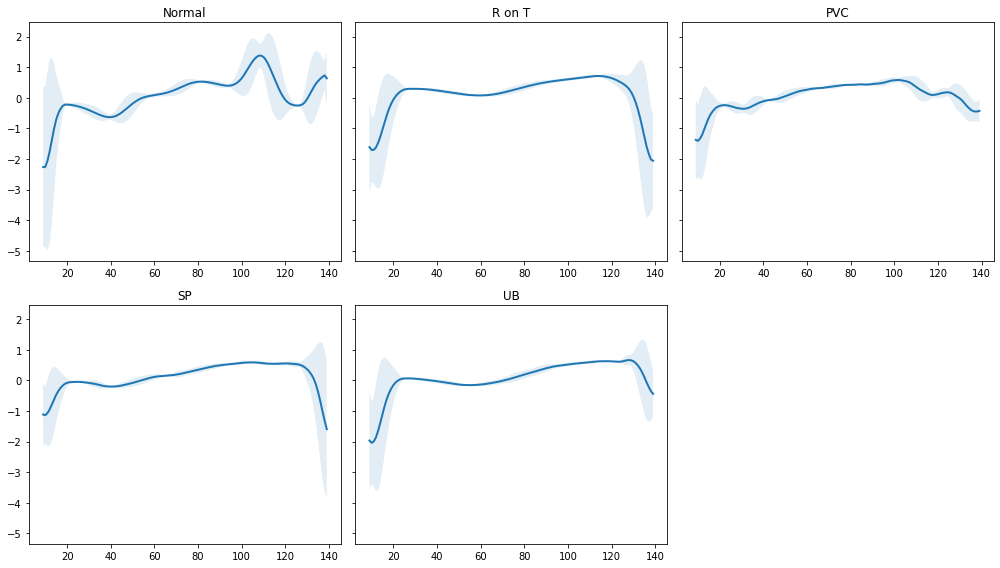

In [ ]:
classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

Not that the normal class has a distinctly different pattern than all other classes.

# Data Preprocessing

In [ ]:
# getting all the normal heartbeats and dropping the target coolumn
normal_df = df[df.target == str(CLASS_NORMAL)].drop(labels='target', axis=1)
normal_df.shape

(2919, 140)

In [ ]:
# merging all other classes and marking them as anomalies
anomaly_df = df[df.target != str(CLASS_NORMAL)].drop(labels='target', axis=1)
anomaly_df.shape

(2081, 140)

In [ ]:
# splitting the normal examples to train, validation and test set

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33, 
  random_state=RANDOM_SEED
)

In [ ]:
# function to convert examples into tensors to train our Autoencoder
def create_dataset(df):
  sequences = df.astype(np.float32).to_numpy().tolist()
  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
  n_seq, seq_len, n_features = torch.stack(dataset).shape
  return dataset, seq_len, n_features

In [ ]:
# converting each Time Series to a 2D Tensor in the shape sequence length x number of features (140x1 in our case).

train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

# LSTM Autoencoder

The Autoencoder's job is to get some input data, pass it through the model, and obtain a reconstruction of the input. The reconstruction should match the input as much as possible. The trick is to use a small number of parameters, so your model learns a compressed representation of the data.

In a sense, Autoencoders try to learn only the most important features (compressed version) of the data. Here, we'll have a look at how to feed Time Series data to an Autoencoder. We'll use a couple of LSTM layers (hence the LSTM Autoencoder) to capture the temporal dependencies of the data.

To classify a sequence as normal or an anomaly, we'll pick a threshold above which a heartbeat is considered abnormal.

The general Autoencoder architecture consists of two components. An Encoder that compresses the input and a Decoder that tries to reconstruct it.

# Reconstruction Loss

When training an Autoencoder, the objective is to reconstruct the input as best as possible. This is done by minimizing a loss function (just like in supervised learning). This function is known as reconstruction loss. Cross-entropy loss and Mean squared error are common examples.



In [ ]:
# model to reconstruct the time series data
# here have used two LSTM layers to compress the Time Series data input
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

In [ ]:
#  decoder to decode the compressed representation
# here have used two LSTM layers and an output layer that gives the final reconstruction
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [ ]:
# wrapping everything into a module for easy-use
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [ ]:
# creating an instance of the model
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

# Training 

In [ ]:
# defining a helper function for training process
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [ ]:
model, history = train_model(
  model, 
  train_dataset, 
  val_dataset, 
  n_epochs=5
)

Epoch 1: train loss 54.818687816436906 val loss 54.537911411845236
Epoch 2: train loss 46.083321538676856 val loss 40.32938255791778
Epoch 3: train loss 42.11707146001506 val loss 42.83007706391527
Epoch 4: train loss 41.646286236379765 val loss 42.607979224403564
Epoch 5: train loss 41.36891257806153 val loss 41.39799651188248


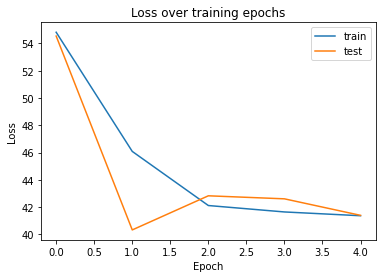

In [ ]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

# Saving the Model

In [ ]:
# storing the model for later use
MODEL_PATH = 'model.pth'

torch.save(model, MODEL_PATH)

# Choosing a Threshold

In [ ]:
# defining a helper function to get predictions from our model
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


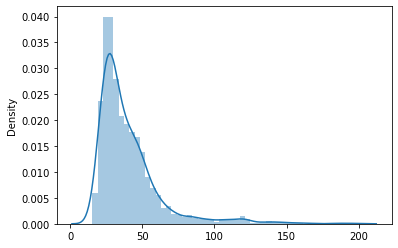

In [ ]:
# getting losses
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True);

In [ ]:
THRESHOLD = 26

# Evaluation
Using the threshold, we can turn the problem into a simple binary classification task:

*   If the reconstruction loss is below the threshold, we'll classify it as a normal heartbeat

*   Alternatively, if the loss is higher than the threshold, we'll classify it as an anomaly



# Normal Heartbeats

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


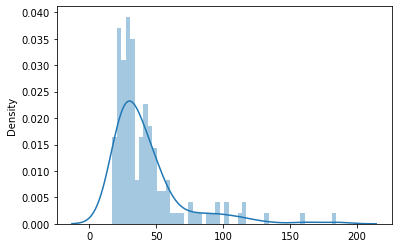

In [ ]:
# using the Normal heartbeats from the test set
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

In [ ]:
# counting the correct predictions
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 38/145


# Anomalies

In [ ]:
# getting a subset of the anomaly examples that has the same size as the normal heartbeats (since their number is much higher)
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


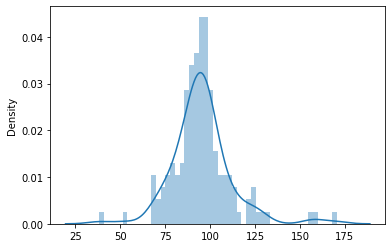

In [ ]:
# taking the predictions of our model for the subset of anomalies
predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

In [ ]:
# counting the number of examples above the threshold (considered as anomalies)
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

Correct anomaly predictions: 145/145


# Analysis

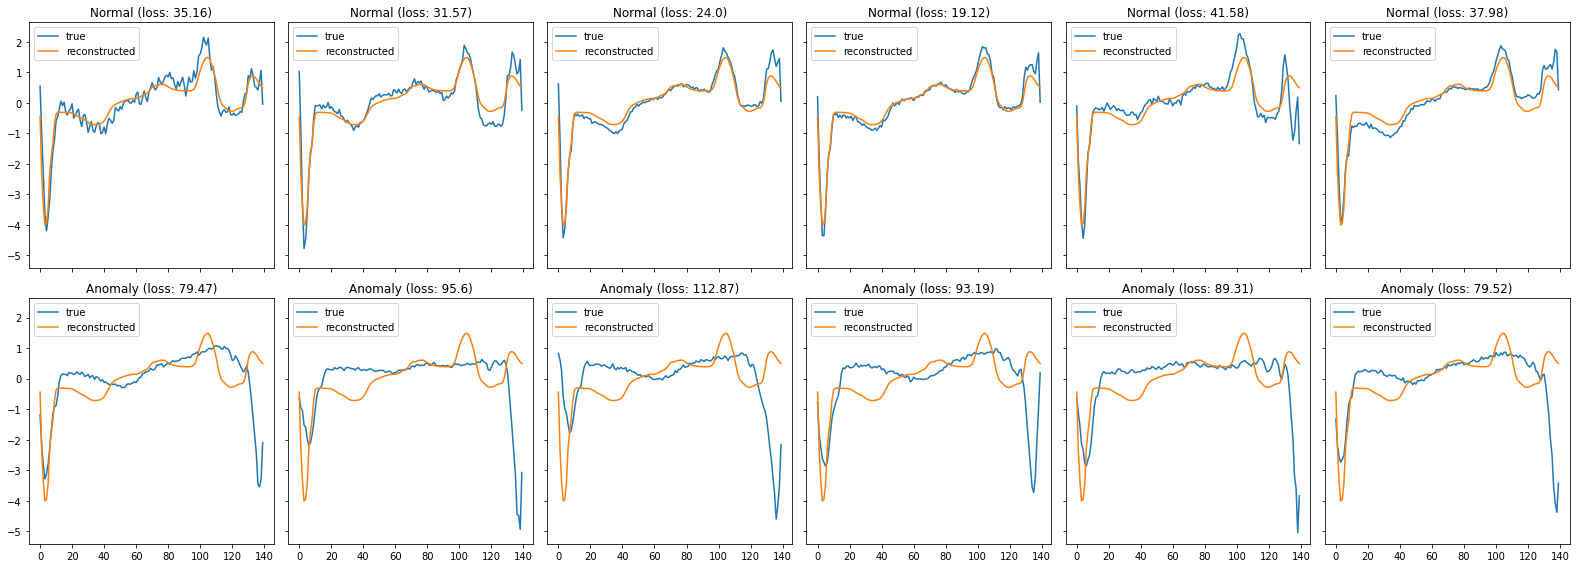

In [ ]:
# overlaying the real and reconstructed Time Series values to see how close they are
# doing it for some normal and anomaly cases
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])

  ax.plot(data, label='true')
  ax.plot(predictions[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:6]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:6]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();